In [1]:
import os
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
import joblib
import torch
import email
from email import policy
from email.parser import BytesParser, HeaderParser
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np

/home/rezett/miniconda3/envs/bert-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

## Prepare Data

In [3]:
# Combine safe and phishing data into a DataFrame
#df_safe = pd.DataFrame(safe_data)
df_safe = pd.read_csv('../trec_ensemble.csv')
df_phishing = pd.read_csv('../phishingpot.csv')
df_combined = pd.concat([df_safe.head(100), df_phishing], ignore_index=True)

In [4]:
df_combined.tail(1)

,received1,received2,received3,received4,received5,received6,received7,received8,received9,received10,...,content-disposition,content-length,sender,importance,received11,received12,received13,received14,received15,received16
199,from DS0PR19MB7299.namprd19.prod.outlook.com (...,from AS4P192CA0020.EURP192.PROD.OUTLOOK.COM (2...,from VI1EUR06FT059.eop-eur06.prod.protection.o...,from providentusezn.co.uk (89.144.44.4) by\n V...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,49413.0,NaN,high,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_combined = df_combined.replace(np.nan, '', regex=True)

In [6]:
df_combined.columns

Index(['received1', 'received2', 'received3', 'received4', 'received5',
       'received6', 'received7', 'received8', 'received9', 'received10',
       'label', 'return-path', 'mailing-list', 'delivered-to', 'received-spf',
       'domainkey-signature', 'message-id', 'from', 'to', 'cc', 'references',
       'subject', 'date', 'mime-version', 'content-type',
       'content-transfer-encoding', 'hops', 'body', 'reply-to', 'in-reply-to',
       'content-disposition', 'content-length', 'sender', 'importance',
       'received11', 'received12', 'received13', 'received14', 'received15',
       'received16'],
      dtype='object')

## Preprocess

### Headers feature extraction

In [7]:
label_name = 'label'

final_features_list = []

In [8]:
def check_received_forged(row):
  num_iters = row['hops']
  col_name_base = 'received'

  for i in range(1, num_iters+1):
    curr_val = row[col_name_base + str(i)]
    if 'forged' in curr_val:
      return 1
    else:
      continue
  return 0

df_combined['received_str_forged'] = df_combined.apply(check_received_forged, axis=1)
final_features_list.append('received_str_forged')

In [9]:
def count_chars(field_names, new_col_names):
  for field_name, new_col_name in zip(field_names, new_col_names):
    df_combined[new_col_name] = df_combined[field_name].str.len()

  final_features_list.extend(new_col_names)

fields_to_find_lengths = ['from']
new_col_names_lengths = []

for val in fields_to_find_lengths:
  new_col_names_lengths.append('length_' + val)

count_chars(fields_to_find_lengths, new_col_names_lengths)

In [10]:
df_combined['num_recipients_to'] = df_combined.apply(lambda x: len(re.findall(
    r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x['to'])), axis=1)

In [11]:
df_combined['num_recipients_cc'] = df_combined.apply(lambda x: len(re.findall(
    r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x['cc'])), axis=1)

In [12]:
df_combined['num_recipients_from'] = df_combined.apply(lambda x: len(re.findall(
    r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', x['from'])), axis=1)

In [13]:
def extract_num_replies(row):
  if 'references' not in row:
    return 0
  references_val = row['references']
  all = re.findall(r'<([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)>', 
                  references_val)
  return len(all)

df_combined['number_replies'] = df_combined.apply(extract_num_replies, axis=1)

In [14]:
# Function to get the last non-empty 'received' field in each row
def get_last_received(row):
    # Loop through the columns from the last to the first
    for i in range(row['hops']-1, 0, -1):
        if row['received'+str(i)] != '':  # Check if the value is not an empty string
            return row['received'+str(i)]
    return ''  # Return empty string if all fields are empty

def date_received_date_comp(row):
  date_date = row['date']
  date_received = row['last_received_date']

  d1 = email.utils.parsedate_tz(date_date)
  d2 = email.utils.parsedate_tz(date_received)

  if d1 is None or d2 is None:
    return -1

  try:
    val1 = email.utils.mktime_tz(d1)
    val2 = email.utils.mktime_tz(d2)
  except:
    return -1

  return (email.utils.mktime_tz(d2)) - (email.utils.mktime_tz(d1))

df_combined['last_received'] = df_combined.apply(get_last_received, axis=1)

df_combined['last_received_date'] = df_combined['last_received'].str.replace('\n\t', ';').str.split(r';').str[-1]

df_combined['date_comp_date_received'] = df_combined.apply(date_received_date_comp, axis=1)

In [15]:
# emails in brackets '<>' are matched first, and if none, then other emails are matched
def extract_emails(row, col_name):

  if col_name not in row:
    return []

  in_brackets = re.findall(r'<([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)>', row[col_name])

  if len(in_brackets) == 0:
    not_in_brackets = re.findall(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', row[col_name])
    if len(not_in_brackets) == 0:
      return []
    else:
      return not_in_brackets
  else:
    return in_brackets

def extract_domains(row, col_name):
  
  if col_name not in row:
    return []

  emails_list = row[col_name]

  if len(emails_list) == 0:
    return []
  else:
    domains_list = []
    for email in emails_list:
      if len(email.split('.')) < 2:
        continue
      else:
        main_domain = email.split('@')[-1]
        main_domain = main_domain.split('.')[-2:]
        main_domain = main_domain[0] + '.' + re.sub('\W+','', main_domain[1])
        domains_list.append(main_domain.lower())
    return domains_list

In [16]:
emails_from = df_combined.apply(extract_emails, col_name='from', axis=1)
emails_message_id = df_combined.apply(extract_emails, col_name='message-id', axis=1)
emails_return_path = df_combined.apply(extract_emails, col_name='return-path', axis=1)
emails_reply_to = df_combined.apply(extract_emails, col_name='reply-to', axis=1)
#emails_errors_to = df_combined.apply(extract_emails, col_name='errors-to', axis=1)
emails_in_reply_to = df_combined.apply(extract_emails, col_name='in-reply-to', axis=1)
emails_references = df_combined.apply(extract_emails, col_name='references', axis=1)
emails_to = df_combined.apply(extract_emails, col_name='to', axis=1)
emails_cc = df_combined.apply(extract_emails, col_name='cc', axis=1)
emails_sender = df_combined.apply(extract_emails, col_name='sender', axis=1)

emails_df = pd.concat([emails_from, emails_message_id, emails_return_path, 
                        emails_reply_to, emails_in_reply_to, 
                        emails_references, emails_to, emails_cc, emails_sender], axis=1)

emails_df.columns = ['from', 'message-id', 'return-path', 'reply-to',
                     'in-reply-to', 'references', 'to', 'cc', 'sender']

In [17]:
domains_from = emails_df.apply(extract_domains, col_name='from', axis=1)
domains_message_id = emails_df.apply(extract_domains, col_name='message-id', axis=1)
domains_return_path = emails_df.apply(extract_domains, col_name='return-path', axis=1)
domains_reply_to = emails_df.apply(extract_domains, col_name='reply-to', axis=1)
#domains_errors_to = emails_df.apply(extract_domains, col_name='errors-to', axis=1)
domains_in_reply_to = emails_df.apply(extract_domains, col_name='in-reply-to', axis=1)
domains_references = emails_df.apply(extract_domains, col_name='references', axis=1)
domains_to = emails_df.apply(extract_domains, col_name='to', axis=1)
domains_cc = emails_df.apply(extract_domains, col_name='cc', axis=1)
domains_sender = emails_df.apply(extract_domains, col_name='sender', axis=1)

domains_df = pd.concat([domains_from, domains_message_id, domains_return_path, 
                        domains_reply_to, domains_in_reply_to, 
                        domains_references, domains_to, domains_cc, domains_sender], axis=1)

domains_df.columns = ['from_domains', 'message-id_domains', 'return-path_domains', 'reply-to_domains',
                     'in-reply-to_domains', 'references_domains', 'to_domains', 'cc_domains', 'sender_domains']

In [18]:
def email_same_check(row, first_col, second_col):
  vals1 = row[first_col]
  vals2 = row[second_col]
  if second_col == 'return-path':
    print(str(vals1) + ' - ' + str(vals2))

  for val1 in vals1:
    for val2 in vals2:
      if val1 == val2:
        return 1

  return 0

emails_to_check = [('from', 'reply-to'), ('from', 'return-path'),]

for val in emails_to_check:
  first_field = val[0]
  second_field = val[1]
  new_col_name = 'email_match_' + first_field + '_' + second_field

  df_combined[new_col_name] = emails_df.apply(email_same_check, first_col=first_field, 
                  second_col=second_field, axis=1)
  final_features_list.append(new_col_name)

['orasnita@gmail.com'] - ['speedy.uwaterloo.ca@perl.org']
['parrotbug-followup@parrotcode.org'] - ['speedy.uwaterloo.ca@perl.org']
['cbtdirect-it-training@find-computer-training.net'] - ['bounce-724252-4606398@find-computer-training.net']
['linux4michelle@freenet.de'] - ['speedy.uwaterloo.ca@lists.debian.org']
['mpg@redhat.com'] - ['sugar-bounces@lists.laptop.org']
['alex_snow@gmx.net'] - ['speakup-bounces@braille.uwo.ca']
['jcristau@debian.org'] - ['speedy.uwaterloo.ca@lists.debian.org']
['alert@broadcast.shareholder.com'] - ['alert@broadcast.shareholder.com']
['jkivlighn@gmail.com'] - ['cc-devel-bounces@lists.ibiblio.org']
['macq@llnl.gov'] - ['r-help-bounces@stat.math.ethz.ch']
['luke@ariadna.cd'] - ['r-help-bounces@stat.math.ethz.ch']
['metze@samba.org'] - ['speedy.uwaterloo.ca@lists.samba.org']
['obnox@samba.org'] - ['speedy.uwaterloo.ca@lists.samba.org']
['k.d.jantzen@t-online.de'] - ['speedy.uwaterloo.ca@perl.org']
['speedy.uwaterloo.ca@cbsig.com'] - ['speedy.uwaterloo.ca@cbsig.

In [19]:
# Returns 0 if no matches, 1 if at least one match
def domain_match_check(row, first_col, second_col):

  first_domain_list = row[first_col]
  second_domain_list = row[second_col]
  if second_col == 'return-path_domains':
    print(str(first_domain_list) + ' - ' + str(second_domain_list))

  if len(first_domain_list) == 0 or len(second_domain_list) == 0:
    return 0
  else:
    for d1 in first_domain_list:
      for d2 in second_domain_list:
        if d1 == d2:
          return 1
    return 0
  
domain_fields_to_check = [('message-id_domains', 'from_domains'), ('from_domains', 'return-path_domains'), ('message-id_domains', 'return-path_domains'), ('message-id_domains', 'sender_domains'), ('message-id_domains', 'reply-to_domains'),
                          ('return-path_domains', 'reply-to_domains'), ('reply-to_domains', 'to_domains'), ('to_domains', 'in-reply-to_domains'), ('sender_domains', 'from_domains'), ('references_domains', 'reply-to_domains'), ('references_domains', 'in-reply-to_domains'), ('references_domains', 'to_domains'), ('from_domains', 'reply-to_domains'),
                          ('to_domains', 'from_domains'), ('to_domains', 'message-id_domains')]

for val in domain_fields_to_check:
  first_field = val[0].replace('_domains', '')
  second_field = val[1].replace('_domains', '')
  new_col_name = 'domain_match_' + first_field + '_' + second_field 

  df_combined[new_col_name] = domains_df.apply(domain_match_check, first_col = val[0], 
                              second_col= val[1], axis=1)
  final_features_list.append(new_col_name)

['gmail.com'] - ['perl.org']
['parrotcode.org'] - ['perl.org']
['find-computer-training.net'] - ['find-computer-training.net']
['freenet.de'] - ['debian.org']
['redhat.com'] - ['laptop.org']
['gmx.net'] - ['uwo.ca']
['debian.org'] - ['debian.org']
['shareholder.com'] - ['shareholder.com']
['gmail.com'] - ['ibiblio.org']
['llnl.gov'] - ['ethz.ch']
['ariadna.cd'] - ['ethz.ch']
['samba.org'] - ['samba.org']
['samba.org'] - ['samba.org']
['t-online.de'] - ['perl.org']
['cbsig.com'] - ['cbsig.com']
['com.au'] - ['constantcontact.com']
['gmail.com'] - ['perl.org']
['co.uk'] - ['co.uk']
['myfreedombox.com'] - ['uwo.ca']
['accuweather.com'] - ['accuweather.com']
['bitbone.de'] - ['perl.org']
['yahoo.com'] - ['ethz.ch']
['comcast.net'] - ['uwo.ca']
['yahoo.com'] - ['perl.org']
['commondreams.org'] - ['groundspring.org']
['pdf.com'] - ['ethz.ch']
['usherbrooke.ca'] - ['ethz.ch']
['theinternetpatrol.com'] - ['aweber.com']
['gmail.com'] - ['perl.org']
['cbsig.com'] - ['cbsig.com']
['fastmail.fm'] 

In [20]:
import dns.resolver

# Function to extract IP addresses from the 'Received' fields of a single row (email)
def extract_ips_from_row(row):
    # Regular expression to capture IP addresses in Received headers
    ip_regex = re.compile(r'\[(\d{1,3}(?:\.\d{1,3}){3})\]')

    # List to hold all extracted IPs
    ips = []

    # Iterate over the received columns for the row
    for col in row.index:
        if 'received' in col:
            # Extract IPs from the current 'received' field
            ips += ip_regex.findall(str(row[col]))

    # Remove duplicates
    return list(set(ips))

# Function to check if any IP in a row is blacklisted
def check_row_for_blacklist(row):
    ips = extract_ips_from_row(row)
    
    if not ips:
        return 0

    servers_blacklisted = 0
    
    # Check each IP and return 1 if any IP is blacklisted
    for ip in ips:
        if check_ip_spamhaus(ip):
            servers_blacklisted += 1

    return servers_blacklisted

def extract_host_ip(row):
    # Regular expression to capture IP addresses in Received headers
    ip_regex = re.compile(r'\[(\d{1,3}(?:\.\d{1,3}){3})\]')

    host = row['received1']
    # Extract IP from the host 'received' field
    host_ip = ip_regex.findall(str(host))
    return host_ip

# Function to check if any IP in a row is blacklisted
def check_host_ip(row):
    host_ip = extract_host_ip(row)
    
    if not host_ip:
        return 0
    
    # Check each IP and return 1 if IP is blacklisted
    if check_ip_spamhaus(host_ip[0]):
        return 1
    return 0

# Function to check if an IP is blacklisted using Spamhaus DNSBL
def check_ip_spamhaus(ip):
    reverse_ip = '.'.join(reversed(ip.split('.')))
    query = f"{reverse_ip}.zen.spamhaus.org"
    
    try:
        # Perform a DNS query to check if the IP is blacklisted
        answers = dns.resolver.resolve(query, 'A')
        print(f"IP {ip} is blacklisted by Spamhaus.")
        return True
    except dns.resolver.NXDOMAIN:
        print(f"IP {ip} is NOT blacklisted by Spamhaus.")
        return False
    except Exception as e:
        print(f"Error querying Spamhaus for IP {ip}: {str(e)}")
        return False

In [21]:
# Apply the blacklist check for each row (email) and store the result in a new column
df_combined['num_servers_blacklisted'] = df_combined.apply(lambda row: check_row_for_blacklist(row), axis=1)

df_combined['host_blacklisted'] = df_combined.apply(lambda row: check_host_ip(row), axis=1)

IP 63.251.223.186 is NOT blacklisted by Spamhaus.
IP 81.180.162.194 is blacklisted by Spamhaus.
IP 63.251.223.186 is NOT blacklisted by Spamhaus.
IP 71.41.80.205 is NOT blacklisted by Spamhaus.
IP 194.97.50.151 is NOT blacklisted by Spamhaus.
IP 127.0.0.1 is NOT blacklisted by Spamhaus.
IP 194.97.50.132 is NOT blacklisted by Spamhaus.
IP 81.56.104.13 is NOT blacklisted by Spamhaus.
IP 70.103.162.31 is NOT blacklisted by Spamhaus.
IP 18.85.46.23 is blacklisted by Spamhaus.
IP 127.0.0.1 is NOT blacklisted by Spamhaus.
IP 172.16.52.254 is NOT blacklisted by Spamhaus.
IP 172.16.76.12 is NOT blacklisted by Spamhaus.
IP 127.0.1.1 is NOT blacklisted by Spamhaus.
IP 18.85.2.148 is blacklisted by Spamhaus.
IP 10.11.14.136 is NOT blacklisted by Spamhaus.
IP 66.187.233.31 is NOT blacklisted by Spamhaus.
IP 24.151.115.123 is blacklisted by Spamhaus.
IP 127.0.0.1 is NOT blacklisted by Spamhaus.
IP 209.225.8.178 is NOT blacklisted by Spamhaus.
IP 10.20.200.155 is NOT blacklisted by Spamhaus.
IP 129.

In [22]:
final_features_list = ['received_str_forged', 'length_from', 'num_recipients_to',
       'num_recipients_cc', 'num_recipients_from', 'number_replies',
       'date_comp_date_received', 'email_match_from_reply-to',
       'email_match_from_return-path', 'domain_match_message-id_from',
       'domain_match_from_return-path', 'domain_match_message-id_return-path',
       'domain_match_message-id_sender', 'domain_match_message-id_reply-to',
       'domain_match_return-path_reply-to', 'domain_match_reply-to_to',
       'domain_match_to_in-reply-to', 'domain_match_sender_from',
       'domain_match_references_reply-to',
       'domain_match_references_in-reply-to', 'domain_match_references_to',
       'domain_match_from_reply-to', 'domain_match_to_from',
       'domain_match_to_message-id', 'num_servers_blacklisted',
       'host_blacklisted', 'body', 'label']

df_combined = df_combined[final_features_list]

In [23]:
df_combined.columns

Index(['received_str_forged', 'length_from', 'num_recipients_to',
       'num_recipients_cc', 'num_recipients_from', 'number_replies',
       'date_comp_date_received', 'email_match_from_reply-to',
       'email_match_from_return-path', 'domain_match_message-id_from',
       'domain_match_from_return-path', 'domain_match_message-id_return-path',
       'domain_match_message-id_sender', 'domain_match_message-id_reply-to',
       'domain_match_return-path_reply-to', 'domain_match_reply-to_to',
       'domain_match_to_in-reply-to', 'domain_match_sender_from',
       'domain_match_references_reply-to',
       'domain_match_references_in-reply-to', 'domain_match_references_to',
       'domain_match_from_reply-to', 'domain_match_to_from',
       'domain_match_to_message-id', 'num_servers_blacklisted',
       'host_blacklisted', 'body', 'label'],
      dtype='object')

In [24]:
def clean_text(text):
    if text is None:
        return None

    # Step 1: Remove quoted-printable encoding artifacts
    text = text.replace('=\n', '')  # Remove soft line breaks
    text = text.replace('=', '')  # Remove remaining '=' characters

    # Step 2: Remove MIME boundaries, content-type, and charset declarations
    mime_pattern = r'(--[-_a-zA-Z0-9]+|Content-[^:]+:[^\n]+\n|charset="[^"]+"|MIME-Version:[^\n]+\n)'
    text = re.sub(mime_pattern, '', text)

    # Step 3: Remove base64-like encoded binary content
    base64_pattern = r'[A-Za-z0-9+/]{40,}={0,2}'
    text = re.sub(base64_pattern, '', text)

    # Step 4: Use BeautifulSoup to remove HTML tags and decode entities
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Step 5: Remove corrupted MIME artifacts or non-readable sequences
    text = re.sub(r'\.[A-Za-z0-9]{7,}', '', text)

    # Step 6: Replace multiple spaces, newlines, or tabs with a single space
    text = re.sub(r'\s+', ' ', text)

    # Step 7: Strip leading and trailing whitespace
    text = text.strip()

    return text

In [25]:
df_combined['body'] = df_combined['body'].apply(clean_text)

/tmp/ipykernel_91162/654631364.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()
/tmp/ipykernel_91162/654631364.py:18: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


## Load models

### Text model

In [26]:
# Get the latest checkpoint
output_dir = "../TextAnalysis/results/bert_lr_2e-5_bs_16_epochs_4"
checkpoints = [f.path for f in os.scandir(output_dir) if f.is_dir() and 'checkpoint' in f.name]
latest_checkpoint = max(checkpoints, key=os.path.getmtime)  # Gets the most recent checkpoint based on modification time

# Load the best model (the one automatically saved at the end of training)
text_model = BertForSequenceClassification.from_pretrained(latest_checkpoint)
text_tokenizer = BertTokenizer.from_pretrained(latest_checkpoint)

### Header model

In [ ]:
header_model = joblib.load('../MetadataAnalysis/models/best_model_gb.pkl')  # Model trained on email headers

### Emotion model

In [34]:
# Load the model for inference or further training
#model_name = "roberta-base"
model_name = "SamLowe/roberta-base-go_emotions"

# Load the saved state_dict
#state_dict = torch.load('../EmotionAnalysis/Models/roberta/4e-05_roberta_model_epoch_10.pth')
state_dict = torch.load('../EmotionAnalysis/Models/14_emotion_reddit_roberta/4e-05_roberta_model_epoch_8.pth')

# Remove the 'model.' prefix from all keys in the state_dict
new_state_dict = {}
for key in state_dict.keys():
    new_key = key.replace('model.', '')  # Remove 'model.' prefix
    new_state_dict[new_key] = state_dict[key]

# Load the modified state_dict into your model
#emotion_model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=14)
emotion_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=14, ignore_mismatched_sizes=True)
emotion_model.load_state_dict(new_state_dict)
emotion_model.eval()  # Set the model to evaluation mode

/tmp/ipykernel_91162/1023872301.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('../EmotionAnalysis/Models/14_emotion_reddit_roberta/4e-05_robert

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Get models outputs for the emails

In [38]:
# Function to preprocess and tokenize email body for BERT and RoBERTa models
def tokenize_email_body(email_body, bert_tokenizer, emotion_tokenizer, max_length=300):
    bert_inputs = bert_tokenizer(email_body, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
    emotion_inputs = emotion_tokenizer(email_body, return_tensors='pt', max_length=256, truncation=True, padding=True)
    return bert_inputs, emotion_inputs

In [39]:
# Function to get predictions from each model
def get_model_predictions(email_body, email_headers, text_model, text_tokenizer, header_model, emotion_model, emotion_tokenizer):
    # 1. BERT model for email body (Text)
    bert_inputs, emotion_inputs = tokenize_email_body(email_body, text_tokenizer, emotion_tokenizer)
    with torch.no_grad():
        bert_output = text_model(**bert_inputs)
        bert_predictions = torch.softmax(bert_output.logits, dim=-1).numpy()

    # 2. Model for email headers
    #header_features = preprocess_headers(email_headers)  # Preprocess the headers
    header_predictions = header_model.predict_proba(email_headers)

    # 3. Emotion model (RoBERTa) for email body
    with torch.no_grad():
        emotion_output = emotion_model(**emotion_inputs)
        emotion_predictions = torch.softmax(emotion_output.logits, dim=-1).numpy()

    return bert_predictions, header_predictions, emotion_predictions

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store predictions and true labels
headers_predictions_list = []
bert_predictions_list = []
true_labels_list = []

# Iterate over the DataFrame to get predictions for each email
for index, row in df_combined.iterrows():
    
    email_body = row['body']  # Extract the body text
    email_headers = row[final_features_list[:-2]]  # Extract all header features
    email_headers = pd.DataFrame([email_headers], columns=final_features_list[:-2])

    # Get predictions from each model
    bert_preds, header_preds, emotion_preds = get_model_predictions(
        email_body, email_headers, text_model, text_tokenizer, header_model, emotion_model, text_tokenizer
    )
    
    # Update the DataFrame with the predictions
    df_combined.at[index, 'bert_prediction'] = bert_preds.argmax()
    df_combined.at[index, 'bert_confidence'] = bert_preds.max()
    df_combined.at[index, 'headers_prediction'] = header_preds.argmax()
    df_combined.at[index, 'headers_confidence'] = header_preds.max()
    df_combined.at[index, 'emotion_prediction'] = emotion_preds.argmax()
    df_combined.at[index, 'emotion_confidence'] = emotion_preds.max()

    # Store the KNN predictions and true labels for accuracy calculation
    headers_predictions_list.append(header_preds.argmax())  # KNN predicted label
    bert_predictions_list.append(bert_preds.argmax())  # BERT predicted label
    true_labels_list.append(row['label'])  # True label from the DataFrame

# Calculate and print the KNN accuracy
header_accuracy = accuracy_score(true_labels_list, headers_predictions_list)
header_precision = precision_score(true_labels_list, headers_predictions_list)
header_recall = recall_score(true_labels_list, headers_predictions_list)
header_f1 = f1_score(true_labels_list, headers_predictions_list)

bert_accuracy = accuracy_score(true_labels_list, bert_predictions_list)
bert_precision = precision_score(true_labels_list, bert_predictions_list)
bert_recall = recall_score(true_labels_list, bert_predictions_list)
bert_f1 = f1_score(true_labels_list, bert_predictions_list)
print(f"Header Model - Accuracy: {header_accuracy}, Precision: {header_precision}, Recall: {header_recall}, F1 Score: {header_f1}")
print(f"BERT Model - Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}, F1 Score: {bert_f1}")

Header Model - Accuracy: 0.885, Precision: 0.9529411764705882, Recall: 0.81, F1 Score: 0.8756756756756757
BERT Model - Accuracy: 0.945, Precision: 0.978494623655914, Recall: 0.91, F1 Score: 0.9430051813471503


Random Forest - Accuracy: 0.975, Precision: 0.975, Recall: 0.9761904761904762, F1 Score: 0.9749843652282677
False Negative Rate: 0.0


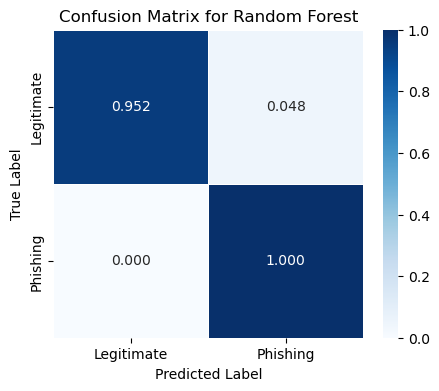

Logistic Regression - Accuracy: 0.95, Precision: 0.9523809523809523, Recall: 0.9523809523809523, F1 Score: 0.95
False Negative Rate: 0.0


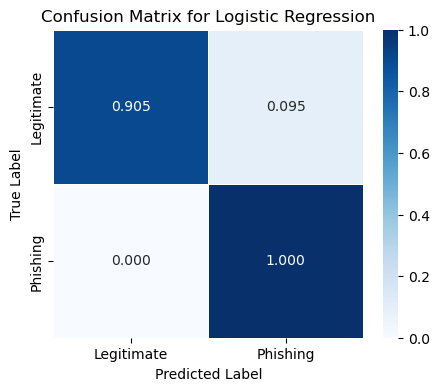

Decision Tree - Accuracy: 0.975, Precision: 0.975, Recall: 0.9761904761904762, F1 Score: 0.9749843652282677
False Negative Rate: 0.0


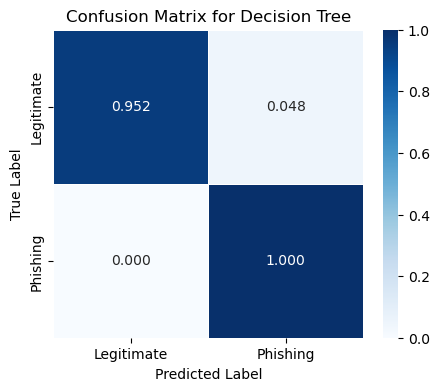

K-Nearest Neighbors - Accuracy: 0.95, Precision: 0.949874686716792, Recall: 0.949874686716792, F1 Score: 0.949874686716792
False Negative Rate: 0.05263157894736842


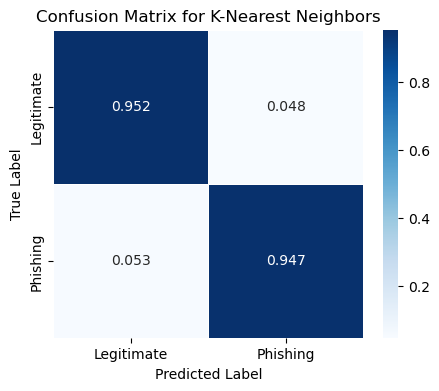

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features for the meta-model
meta_features = [
    'bert_prediction', 
    'headers_prediction',
    'emotion_prediction',
]

X = df_combined[meta_features]
y = df_combined['label']  # True labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def plot_conf_matrix(conf_matrix, model_name):
    # Normalize the confusion matrix to percentages
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.3f', cmap='Blues', cbar=True, linewidths=0.5,
                xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
    ax.set_title(f"Confusion Matrix for {model_name}")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    plt.show()

def model_train_and_eval(meta_model, model_name):
    meta_model.fit(X_train, y_train)
    y_pred = meta_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    fn = conf_matrix[1][0]  # False Negatives
    fnr = fn / (fn + conf_matrix[1][1])  # False Negative Rate
    print(f"{model_name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    print(f"False Negative Rate: {fnr}")
    # Plot the confusion matrix
    plot_conf_matrix(conf_matrix, model_name)

# Train a meta-classifier (Random Forest in this case)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
model_train_and_eval(rf_model, "Random Forest")

# 2. Logistic Regression
logistic_model = LogisticRegression(random_state=42)
model_train_and_eval(logistic_model, "Logistic Regression")

# 3. Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=42)
model_train_and_eval(decision_tree_model, "Decision Tree")

# 4. K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed
model_train_and_eval(knn_model, "K-Nearest Neighbors")

In [65]:
# Save the models
joblib.dump(rf_model, './results/rf_meta_model.pkl')
joblib.dump(logistic_model, './results/lr_meta_model.pkl')
joblib.dump(decision_tree_model, './results/dt_model.pkl')
joblib.dump(knn_model, './results/knn_meta_model.pkl')

['./results/knn_meta_model.pkl']

In [41]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

features_names = X_train.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature - {features_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature - bert_prediction (0.5493373122135821)
2. feature - headers_prediction (0.39745778562137135)
3. feature - emotion_prediction (0.05320490216504657)


: 

In [59]:
df_combined.columns

Index(['received_str_forged', 'length_from', 'num_recipients_to',
       'num_recipients_cc', 'num_recipients_from', 'number_replies',
       'date_comp_date_received', 'email_match_from_reply-to',
       'email_match_from_return-path', 'domain_match_message-id_from',
       'domain_match_from_return-path', 'domain_match_message-id_return-path',
       'domain_match_message-id_sender', 'domain_match_message-id_reply-to',
       'domain_match_return-path_reply-to', 'domain_match_reply-to_to',
       'domain_match_to_in-reply-to', 'domain_match_sender_from',
       'domain_match_references_reply-to',
       'domain_match_references_in-reply-to', 'domain_match_references_to',
       'domain_match_from_reply-to', 'domain_match_to_from',
       'domain_match_to_message-id', 'num_servers_blacklisted',
       'host_blacklisted', 'body', 'label', 'bert_prediction',
       'bert_confidence', 'headers_prediction', 'headers_confidence',
       'emotion_prediction', 'emotion_confidence'],
      dt

In [60]:
df_combined['email_match_from_return-path'].tail(50)

150    1
151    0
152    0
153    0
154    0
155    0
156    0
157    1
158    0
159    0
160    0
161    1
162    0
163    0
164    1
165    1
166    0
167    0
168    0
169    0
170    0
171    0
172    1
173    0
174    0
175    0
176    0
177    0
178    1
179    0
180    0
181    0
182    1
183    0
184    0
185    0
186    0
187    1
188    0
189    0
190    0
191    0
192    1
193    1
194    0
195    0
196    0
197    0
198    0
199    0
Name: email_match_from_return-path, dtype: int64

In [61]:
df_combined.tail(50)

,received_str_forged,length_from,num_recipients_to,num_recipients_cc,num_recipients_from,number_replies,date_comp_date_received,email_match_from_reply-to,email_match_from_return-path,domain_match_message-id_from,...,num_servers_blacklisted,host_blacklisted,body,label,bert_prediction,bert_confidence,headers_prediction,headers_confidence,emotion_prediction,emotion_confidence
150,0,46,0,0,1,0,4,0,1,1,...,0,0,Você precisa de um empréstimo? Concedemos empr...,1,1.0,0.999527,1.0,0.999979,10.0,0.332984
151,0,35,0,0,1,0,8673,0,0,0,...,0,0,"Quanto mais pontos melhor Oi, rodrigo-f-p@hotm...",1,1.0,0.999786,0.0,0.948140,1.0,0.831487
152,0,58,0,0,1,0,0,0,0,0,...,0,0,Microsoft account Unusual sign.in activity We ...,1,1.0,0.999878,1.0,0.745589,1.0,0.848170
153,0,58,0,0,1,0,0,0,0,0,...,0,0,Microsoft account Unusual sign.in activity We ...,1,1.0,0.999874,1.0,0.745589,1.0,0.866282
154,0,67,0,0,1,0,95,0,0,0,...,0,0,SCHMELZENFAT SCHNELL! OHNE DIAT ODER SPORT 😍Ke...,1,1.0,0.999741,1.0,0.999168,7.0,0.922706
155,0,52,0,0,1,0,33,0,0,0,...,0,0,"Herzlichen Glückwunsch phishing@pot, wir gratu...",1,1.0,0.999586,0.0,0.847209,7.0,0.861201
156,0,53,0,0,1,0,167,0,0,0,...,0,0,Pontos Livelo BRADESCO Prezado(a) Cliente Você...,1,1.0,0.999713,1.0,0.976759,1.0,0.797515
157,0,48,0,0,1,0,1,0,1,1,...,0,0,b'\n\n\n \n \n \n \n \n | \n \n \n \n | \n \n ...,1,0.0,0.999878,1.0,0.999967,7.0,0.837667
158,0,58,0,0,1,0,0,0,0,0,...,0,0,Microsoft account Unusual sign.in activity We ...,1,1.0,0.999876,1.0,0.745589,1.0,0.841650
159,0,67,0,0,1,0,55,0,0,0,...,0,0,SCHMELZENFAT SCHNELL! OHNE DIAT ODER SPORT 😍Ke...,1,1.0,0.999741,1.0,0.998665,7.0,0.922706
